In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import lmfit
from tqdm import tqdm
import xarray as xr
from glotaran.optimization.optimize import optimize
from glotaran.io import load_model
from glotaran.io import load_parameters
from glotaran.io import save_dataset
from glotaran.io.prepare_dataset import prepare_time_trace_dataset
from glotaran.project.scheme import Scheme

In [8]:
# load all and average the matrix
def mat_avg(name, file_num):
    first_array = np.loadtxt(name+str(1))-np.loadtxt(name+str(1))
    rows = len(first_array)
    columns = len(first_array[0])
    mat_array = np.zeros((rows, columns, file_num))
    for i in range(file_num):
        mat_array[:, :, i] = np.loadtxt(name+str(i+1))
        # print(data_file)
    sum_array = np.sum(mat_array, axis=2)
    avg_array = sum_array / file_num
    np.savetxt(name+"averaged", avg_array, fmt="%f", delimiter="\t")
    return avg_array, mat_array

# load TaTime0
def load_tatime(file_name):
    time_total = np.loadtxt(file_name)[:, 0]
    tatime = time_total[time_total != 0]
    return tatime

# load TaWavelength0
def load_tawavelength(file_name):
    tawavelength = np.loadtxt(file_name)[:, 1]
    return tawavelength

# auto load all parallel expts into the object load_spectra
class load_spectra:
    def __init__(self, file_inp, num_spec):
        self.file_inp = file_inp
        self.num_spec = num_spec
        # load tatime0 and tawavelength0 axes
        self.tatime0 = load_tatime(self.file_inp+'1')
        self.tawavelength0 = load_tawavelength(self.file_inp+'1')
        # average the matrix
        self.tamatrix_avg, self.mat_array = mat_avg(self.file_inp, num_spec)
        self.fig_k, self.ax_k = plt.subplots()

    # plot 1ps spectrum
    def get_1ps(self):
        diff = np.abs(self.tatime0 - 1)
        pt = pt = np.argmin(diff)
        self.spec_1ps = self.tamatrix_avg[:, pt+2]
        self.fig_s, self.ax_s = plt.subplots()
        self.ax_s.plot(self.tawavelength0, self.spec_1ps)
        self.ax_s.set_title(self.file_inp)
        self.ax_s.set_xlabel('Wavelength (nm)')
        self.ax_s.set_ylabel('ΔOD')
        return self.spec_1ps

    # plot multiple parallel traces to see photodamage
    def get_traces(self, wavelength):
        self.trace_array = np.zeros((len(self.tatime0)+1, self.num_spec))
        diff = np.abs(self.tawavelength0 - wavelength)
        pt = np.argmin(diff)

        for i in range(self.num_spec):
            self.trace_array[:, i] = self.mat_array[pt, 2:, i]
            try:
                self.ax_k.plot(
                    self.tatime0, self.trace_array[:, i], label=f'{wavelength} nm trace {i+1}')
            except:
                self.ax_k.plot(
                    self.tatime0, self.trace_array[:-1, i], label=f'{wavelength} nm trace {i+1}')
        self.trace_avg = self.tamatrix_avg[pt, 2:]
        try:
            self.ax_k.plot(self.tatime0, self.trace_avg,
                           label=f'{wavelength} nm trace averaged')
        except:
            self.ax_k.plot(
                self.tatime0, self.trace_avg[:-1], label=f'{wavelength} nm trace averaged')
        self.ax_k.legend()
        self.ax_k.set_xlabel('Time (ps)')
        self.ax_k.set_ylabel('ΔOD')
        self.ax_k.set_title(self.file_inp)

        return self.trace_avg
    
#compare traces from load_spectra object
class compare_traces:
    def __init__(self, obj, wavelength):
        self.wavelength = wavelength
        self.tatime0 = obj.tatime0
        trace = obj.get_traces(wavelength, disable_plot = True).reshape(1, -1)
        self.trace_array = np.empty((0,len(self.tatime0)))
        print(self.trace_array.size)
        print(trace.size)
        self.trace_array = np.append(self.trace_array, trace, axis = 0)
        self.wavelength_list = [self.wavelength]  
        self.name_list =  [obj.file_inp]      
    def add_trace(self,obj,wavelength = None):
        self.name_list.append(obj.file_inp)
        if wavelength is None:
            trace_toadd = obj.get_traces(self.wavelength, disable_plot = True).reshape(1, -1)
            self.wavelength_list.append(self.wavelength)
        else:
            try:
                trace_toadd = obj.get_traces(wavelength, disable_plot = True).reshape(1, -1)
                self.wavelength_list.append(wavelength)
            except:
                print('Invalid wavelength')
                return
        self.trace_array = np.append(self.trace_array,trace_toadd, axis = 0)
    
    def plot(self):
        self.fig, self.ax = plt.subplots()
        for i in range(len(self.trace_array)):
            self.ax.plot(np.log(self.tatime0),self.trace_array[i,:]/np.max(np.abs(self.trace_array[i,:])), label = f'{self.name_list[i]} @ {self.wavelength_list[i]} nm')
        self.ax.legend()
        self.ax.set_title('Normalized traces with logarithmic time axis')
        self.ax.set_xlabel('Time (Log scale ps)')
        self.ax.set_ylabel('ΔOD')
            
class glotaran:
    def __init__(self,matrix_corr,tatime0,tawavelength0):
        self.filename = matrix_corr
        self.tatime0 = np.loadtxt(tatime0)
        self.tawavelength0 = np.loadtxt(tawavelength0)
        self.output_matrix = np.loadtxt(matrix_corr)
        self.output_matrix = np.append(self.tatime0.reshape(1,-1),self.output_matrix, axis = 0)
        self.output_matrix = np.append(np.append("",self.tawavelength0).reshape(1,-1).T,self.output_matrix, axis = 1)
        self.header = self.filename+'\n\nTime explicit\nintervalnr '+ str(len(self.tatime0))
        np.savetxt(self.filename+"glo.ascii",self.output_matrix,header = self.header,fmt='%s',comments='',delimiter = '\t')
        

In [6]:
class tamatrix_importer:
    def __init__(self,filename,startnm = None, endnm = None):
        if startnm is None:
            self.startnm = 0
        else:
            self.startnm = startnm
        if endnm is None:
            self.endnm = 1200
        else:
            self.endnm = endnm
        
        # Load firstcol wave and find startrow and endrow
        # filename = input("Enter the filename for firstcol wave: ")
        self.filename = filename
        firstcol = np.loadtxt(self.filename)[:, 1]
        if self.startnm < np.min(firstcol):
            self.startrow = np.argmin(firstcol)
        else:
            for index in range(len(firstcol)):
                if firstcol[index] > self.startnm:
                    self.startrow = index
                    break
        if self.endnm > np.max(firstcol):
            self.endrow = np.argmax(firstcol)
        else:
            for index in range(len(firstcol)):
                if firstcol[index] > self.endnm:
                    self.endrow = index
                    break

        # Load TAwavelength waves
        self.tawavelength = np.loadtxt(self.filename, skiprows=self.startrow, max_rows=self.endrow-self.startrow)[:,1]
        #np.savetxt(self.filename+"_tawavelength",tawavelength,fmt='%1.5f')

        # Trim TAtime wave
        self.tatime = np.loadtxt(self.filename)[:,0]
        idx = np.loadtxt(self.filename).shape[1]-2
        self.tatime = self.tatime[:idx]
        #np.savetxt(self.filename+"_tatime",tatime,fmt='%1.5f')

        # Load TAmatrix waves
        self.tamatrix = np.loadtxt(self.filename, skiprows=self.startrow, max_rows=self.endrow-self.startrow, usecols=np.arange(2, idx+2))
        #np.savetxt(self.filename+"_tamatrix",self.tamatrix,fmt='%1.5f')

    def contour(self,time_min,time_max):
        # Create a contour plot
        Y, X = np.meshgrid(self.tatime, self.tawavelength)
        plt.contourf(X,Y,self.tamatrix,[-0.005,-0.001,-0.0005,0,0.0005,0.001,0.005],cmap='rainbow')
        plt.ylim(time_min,time_max)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Time (ps)")
        plt.colorbar()
        plt.show()

    def save_all(self,filename,mat):
        if mat == 'original':
            matrix = self.tamatrix.copy()
            print("Original matrix is selected\n")
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
            print("Background corrected matrix is selected\n")
        else:
            matrix = self.tcorr.copy()
            print("Background and Zero time corrected matrix is selected\n")
        np.savetxt(filename+"_tawavelength",self.tawavelength,fmt='%1.5f')
        print(filename+"_tawavelength has been saved\n")
        np.savetxt(filename+"_tatime",self.tatime,fmt='%1.5f')
        print(filename+"_tatime has been saved\n")
        np.savetxt(filename+"_tamatrix",matrix,fmt='%1.5f')
        print(filename+"_tatime has been saved\n")
        

    def save_tamatrix(self,filename, mat=None):
        if mat is None:
            matrix = self.tcorr.copy()
            print("Background and Zero time corrected matrix is selected\n")
        if mat == 'original':
            matrix = self.tamatrix.copy()
            print("Original matrix is selected\n")
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
            print("Background corrected matrix is selected\n")
        else:
            matrix = self.tcorr.copy()
            print("Background and Zero time corrected matrix is selected\n")
        if filename == self.filename:
            print("Cannot overwrite original matrix, choose another name\n")
        else:
            np.savetxt(filename+"_tamatrix",matrix,fmt='%1.5f')
    
    def save_tatime(self,filename):
        np.savetxt(filename+"_tatime",self.tatime,fmt='%1.5f')

    def save_tawavelength(self,filename):
        np.savetxt(filename+"_tawavelength",self.tawavelength,fmt='%1.5f')
        
    def save_axes(self, filename):
        np.savetxt(filename+"_tatime",self.tatime,fmt='%1.5f')
        np.savetxt(filename+"_tawavelength",self.tawavelength,fmt='%1.5f')

    def auto_bgcorr(self, points):
        npavg = 0
        self.bgcorr = self.tamatrix.copy()
        for i in range(points):
            npavg += self.tamatrix[:, i]

        print("The number of time points taken as background: "+str(i+1))
        npavg /= points
        #np.savetxt(self.filename+"_tamatrix_npavg", npavg, fmt='%1.5f')
        for x in range(self.tamatrix.shape[1]):
            self.bgcorr[:, x] = self.tamatrix[:, x] - npavg
        #np.savetxt(self.tamatrix+"_tamatrix_bgcorr", self.bgcorr, fmt='%1.5f')

        # Create a figure and axis for the contour plot
        # Create contour plot
        Y, X = np.meshgrid(self.tatime, self.tawavelength)
        plt.contourf(X, Y, self.bgcorr, [-0.005, -0.001, -0.0005,
                 0, 0.0005, 0.001, 0.005], cmap='rainbow')
        plt.ylim(-1, 1)
        plt.colorbar()
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Time (ps)")
        plt.show()

        return self.bgcorr
    # zero time correction

    def auto_tcorr(self, line_file):
        '''
        This macro corrects a TA matrix (time versus wavelength or wavenumber) for the measured chirp in the continuum.
        To use it first plot the TA matrix as a contour plot and zoom in on the region around zerotime, say -1 ps to +1 ps.
        Then use the "correction_line.py" tool to draw in a contour that follows the curvature of the onset of the signal.
        Typically this curve would be lower, at more negative times, in the blue part of the spectrum and then extending up
        to more positive time delays in the red part of the spectrum.
        To get the "Draw Wave Monotonic" tool, first <Show Tools>, then right click + option button on the polygon tool. Select
        "Draw wave Monotonic" and then click along to place data points on the contour plot, double clicking when you reach the last one.
        This will make two waves, named something like W_Ypoly0 (the y points) and W_XPoly0 (the x points).
        "matrix" is the name of the TA matrix you are correcting, e.g. "TAmatrix0".
        "TAtime" is the name if the time axis, e.g. "TAtime0"
        "TAwavelength" is the name of the wavelength axis, e.g. "TAwavelength0"
        "zerotime_x" is the wave with the x values of the zerotime wave drawn above, e.g. "W_XPoly0"
        "zerotime_y" is the wave with the y values of the zerotime wave drawn above, e.g. "W_YPoly0"
        Note that you could also fit the kinetics at a lot of different wavelengths and thereby determine a series of zerotimes ("zerotime_y")
        at a series of wavelengths ("zerotime_x")
        So you'd call this macro with a command line like: Correct_zerotime("TAmatrix0","TAtime0", "TAwavelength0","W_XPoly0","W_YPoly0")
        '''

        # import correction line from drawing script
        zerotime_x = np.loadtxt(line_file)[:, 0]
        zerotime_y = np.loadtxt(line_file)[:, 1]
        # generate contempory file and output matrix
        time_temp = self.tatime.copy()
        try:
            oldmatrix = self.bgcorr.copy()
        except:
            print('bgcorr matrix not found. zero time correction on original matrix')
            oldmatrix = self.tamatrix.copy()
        self.tcorr = np.zeros_like(self.tamatrix)

        for i in range(len(self.tawavelength)):
            # Tatime axis minus time offset from the drawn line
            time_temp = self.tatime + np.interp(self.tawavelength[i], zerotime_x, zerotime_y)
            # extrapolate TAsignal to match corrected time axis
            self.tcorr[i, :] = np.interp(time_temp, self.tatime, oldmatrix[i, :])
            # Add the following smoothing line to clean up the spectra, with a slight loss in time resolution.
            # newmatrix[i, :] = np.convolve(kin_temp2[i, :], np.ones(3)/3, mode='same')
        #save tcorred matrix
        #np.savetxt(newmatrixname, newmatrix, fmt='%1.5f')
        
        # Create contour plot with plot_contour()
        # Create contour plot
        fig, ax = plt.subplots()
        Y, X = np.meshgrid(self.tatime, self.tawavelength)
        contour = ax.contour(
            X, Y, self.tcorr, [-0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01])
        plt.ylim(-1, 1)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Time (ps)")
        plt.draw()
    
        return self.tcorr
    
    def auto_tcorr_fit(self):
        '''
        This macro corrects a TA matrix (time versus wavelength or wavenumber) for the measured chirp in the continuum.
        To use it first plot the TA matrix as a contour plot and zoom in on the region around zerotime, say -1 ps to +1 ps.
        Then use the "correction_line.py" tool to draw in a contour that follows the curvature of the onset of the signal.
        Typically this curve would be lower, at more negative times, in the blue part of the spectrum and then extending up
        to more positive time delays in the red part of the spectrum.
        To get the "Draw Wave Monotonic" tool, first <Show Tools>, then right click + option button on the polygon tool. Select
        "Draw wave Monotonic" and then click along to place data points on the contour plot, double clicking when you reach the last one.
        This will make two waves, named something like W_Ypoly0 (the y points) and W_XPoly0 (the x points).
        "matrix" is the name of the TA matrix you are correcting, e.g. "TAmatrix0".
        "TAtime" is the name if the time axis, e.g. "TAtime0"
        "TAwavelength" is the name of the wavelength axis, e.g. "TAwavelength0"
        "zerotime_x" is the wave with the x values of the zerotime wave drawn above, e.g. "W_XPoly0"
        "zerotime_y" is the wave with the y values of the zerotime wave drawn above, e.g. "W_YPoly0"
        Note that you could also fit the kinetics at a lot of different wavelengths and thereby determine a series of zerotimes ("zerotime_y")
        at a series of wavelengths ("zerotime_x")
        So you'd call this macro with a command line like: Correct_zerotime("TAmatrix0","TAtime0", "TAwavelength0","W_XPoly0","W_YPoly0")
        '''

        # import correction line from drawing script
        zerotime_x = self.t0_list[:, 1]
        zerotime_y = self.t0_list[:, 2]
        # generate contempory file and output matrix
        time_temp = self.tatime.copy()
        oldmatrix = self.bgcorr.copy()
        self.tcorr = np.zeros_like(self.tamatrix)

        for i in range(len(self.tawavelength)):
            # Tatime axis minus time offset from the drawn line
            time_temp = self.tatime + np.interp(self.tawavelength[i], zerotime_x, zerotime_y)
            # extrapolate TAsignal to match corrected time axis
            self.tcorr[i, :] = np.interp(time_temp, self.tatime, oldmatrix[i, :])
            # Add the following smoothing line to clean up the spectra, with a slight loss in time resolution.
            # newmatrix[i, :] = np.convolve(kin_temp2[i, :], np.ones(3)/3, mode='same')
        #save tcorred matrix
        #np.savetxt(newmatrixname, newmatrix, fmt='%1.5f')
        
        # Create contour plot with plot_contour()
        # Create contour plot
        fig, ax = plt.subplots()
        Y, X = np.meshgrid(self.tatime, self.tawavelength)
        contour = ax.contour(
            X, Y, self.tcorr, [-0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01])
        plt.ylim(-1, 1)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Time (ps)")
        plt.draw()
    
        return self.tcorr
    
    def glotaran(self):
        output_matrix = glotaran(self.tcorr,self.tatime,self.tawavelength)
        #return output_matrix #Don't need this array in python. Use Glotaran legacy 
    
    def pyglotaran(self,mat=None):
        '''
        export tcorr matrix to pyglotaran xarray dataset
        e.g.
        dataset = tamatrix.pyglotaran()
        '''
        time_vals = self.tatime
        spectral_vals = self.tawavelength
        data_vals = self.mat_selector(mat).T

        # Define dimensions and coordinates
        dims = ('time', 'spectral')
        coords = {'time': time_vals, 'spectral': spectral_vals}

        # Create xarray dataset
        dataset = xr.Dataset(
            {'data': (dims, data_vals)},
            coords=coords,
            attrs={'source_path': 'dataset_1.nc'}
        )
        print(dataset)
        return dataset
    
    def mat_selector(self,mat=None):
        if mat is None:
            try:   
                matrix = self.tcorr.copy()
            except:
                try:
                    matrix = self.bgcorr.copy()
                    print('Background corrected matrix used')
                except:
                    matrix = self.tamatrix.copy()
                    print('Original matrix used')
        elif mat == 'original':
            matrix = self.tamatrix.copy()
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
        elif mat == 'tcorr':
            matrix = self.tcorr.copy()
        else:
            try:   
                matrix = self.tcorr.copy()
                print('Invalid mat value. Use tcorrrected matrix')
            except:
                try:
                    matrix = self.bgcorr.copy()
                    print('Invalid mat value. Background corrected matrix used')
                except:
                    matrix = self.tamatrix.copy()
                    print('Invalid mat value. Original matrix used')
        return matrix
            
    def auto_taspectra(self,time_pts=None, mat=None):
        #sample time_pts = [-0.5,-0.2, 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]
        if time_pts is None:
            time_pts = [-0.5,-0.2, 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]
        '''
        if mat is None:
            try:   
                matrix = self.tcorr.copy()
            except:
                try:
                    matrix = self.bgcorr.copy()
                    print('Background corrected matrix used')
                except:
                    matrix = self.tamatrix.copy()
                    print('Original matrix used')
        elif mat == 'original':
            matrix = self.tamatrix.copy()
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
        elif mat == 'tcorr':
            matrix = self.tcorr.copy()
        else:
            try:   
                matrix = self.tcorr.copy()
                print('Invalid mat value. Use tcorrrected matrix')
            except:
                try:
                    matrix = self.bgcorr.copy()
                    print('Invalid mat value. Background corrected matrix used')
                except:
                    matrix = self.tamatrix.copy()
                    print('Invalid mat value. Original matrix used')
        '''   
        matrix = self.mat_selector(mat)       
        
        #find closest time points
        time_index = find_closest_value(time_pts,self.tatime)
        self.spectra_set = self.tawavelength.copy()
        #plot spectra together
        for i in range(len(time_index)):
            spec = matrix[:,time_index[i]]
            self.spectra_set = np.c_[self.spectra_set,spec]
            plt.plot(self.tawavelength,spec,label = '{:.2f}'.format(self.tatime[time_index[i]])+"ps")
        plt.ylim(-0.05,0.05)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        return self.spectra_set

    def save_taspectra(self, name,time_pts, mat):
        #sample time_pts = [-0.5,-0.2, 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]
        #find closest time points
        time_index = find_closest_value(time_pts,self.tatime)
        self.spectra_set = self.tawavelength.copy()
        header_str = 'Wavelength\t'
        if mat == 'original':
            matrix = self.tamatrix.copy()
            print("Original matrix is selected\n")
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
            print("Background corrected matrix is selected\n")
        else:
            matrix = self.tcorr.copy()
            print("Background and Zero time corrected matrix is selected\n")
        for time in time_index:
            header_str= header_str+"s_"+name+"_"+'{:.2f}'.format(self.tatime[time])+"ps\t"
        #plot spectra together
        for i in range(len(time_index)):
            spec = matrix[:,time_index[i]]
            print(time_index[i])
            self.spectra_set = np.c_[self.spectra_set,spec]
            plt.plot(self.tawavelength,spec,label = '{:.2f}'.format(self.tatime[time_index[i]])+"ps")

        np.savetxt("s_"+name, self.spectra_set,header=header_str,fmt = '%1.5f',delimiter = '\t')
        print("File s_"+name+" has been saved\n")
        plt.ylim(-0.2,0.2)
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        return self.spectra_set

    def get_spectrum(self, name, time_pt, mat=None,):
        if mat is None:
            matrix = self.tcorr.copy()
        elif mat == 'original':
            matrix = self.tamatrix.copy()
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
        elif mat == 'tcorr':
            matrix = self.tcorr.copy()
        else:
            print("invalid matrix selection, enter original, bgcorr or tcorr\n")
        diff = self.tatime.copy() - time_pt
        index = np.argmin(np.abs(diff))
        np.savetxt("s_"+name+"_"+'{:.2f}'.format(self.tatime[index])+" ps", matrix[:,index],fmt = '%1.5f')
        print("File s_"+name+"_"+'{:.2f}'.format(self.tatime[index])+" ps has been saved\n")
        plt.plot(self.tawavelength, matrix[:,index], label= '{:.2f}'.format(self.tatime[index])+"ps" )
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        return matrix[:,index]
    
    def return_spectrum(self,tamatrix,time_pt):
        diff = self.tatime.copy() - time_pt
        index = np.argmin(np.abs(diff))
        plt.plot(self.tawavelength, tamatrix[:,index], label= '{:.2f}'.format(self.tatime[index])+"ps" )
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        return tamatrix[:,index]

    def auto_takinetics(self,wavelength_pts,mat):
        #sample time_pts = [-0.5,-0.2, 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]
        #find closest time points
        wavelength_index = find_closest_value(wavelength_pts,self.tawavelength)
        if mat == 'original':
            matrix = self.tamatrix.copy()
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
        else:
            matrix = self.tcorr.copy()
            print("output zero time corrected kinetics")
        #plot spectra together
        for i in range(len(wavelength_index)):
            spec = matrix[wavelength_index[i],:].T
            plt.plot(self.tatime,spec,label = '{:.2f}'.format(self.tawavelength[wavelength_index[i]])+" nm")
        plt.xlabel("Time (ps)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()

    def save_takinetics(self,name,wavelength_pts, mat):
        #sample time_pts = [-0.5,-0.2, 0, 0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 1500]
        #find closest time points
        wavelength_index = find_closest_value(wavelength_pts,self.tawavelength)
        self.kinetics_set = self.tatime.copy()
        header_str = 'Time(ps)\t'
        for wavelength in wavelength_index:
            header_str= header_str+"k_"+name+"_"+'{:.2f}'.format(self.tawavelength[wavelength])+"nm\t"
        if mat == 'original':
            matrix = self.tamatrix.copy()
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
        else:
            matrix = self.tcorr.copy()
            print("output zero time corrected kinetics")
        #plot spectra together
        for i in range(len(wavelength_index)):
            spec = matrix[wavelength_index[i],:].T
            self.kinetics_set = np.c_[self.kinetics_set,spec]
            plt.plot(self.tatime,spec,label = '{:.2f}'.format(self.tawavelength[wavelength_index[i]])+" nm")
        np.savetxt("k_"+name, self.kinetics_set,header=header_str,fmt = '%1.5f',delimiter = '\t')
        plt.xlabel("Time (ps)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        
        return self.kinetics_set
        
    def get_kinetic(self,name,wavelength_pt,mat):
        if mat == 'original':
            matrix = self.tamatrix.copy()
        elif mat == 'bgcorr':
            matrix = self.bgcorr.copy()
        else:
            matrix = self.tcorr.copy()
            print("output zero time corrected kinetics")
        #plot spectra together
        diff = np.abs(self.tawavelength - wavelength_pt)
        wavelength_index = np.argmin(np.abs(diff))
        plt.plot(self.tatime,matrix[wavelength_index,:],label = '{:.2f}'.format(self.tawavelength[wavelength_index])+" nm")
        np.savetxt("k_"+name+"_"+'{:.2f}'.format(self.tawavelength[wavelength_index])+"nm", matrix[wavelength_index,:].T,fmt = '%1.5f',delimiter = '\t')
        plt.xlabel("Time (ps)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        return matrix[wavelength_index,:]
    
    def return_kinetic(self,tamatrix,wavelength_pt):
        #plot spectra together
        diff = np.abs(self.tawavelength - wavelength_pt)
        wavelength_index = np.argmin(np.abs(diff))
        plt.plot(self.tatime,tamatrix[wavelength_index,:],label = '{:.2f}'.format(self.tawavelength[wavelength_index])+" nm")
        plt.xlabel("Time (ps)")
        plt.ylabel("ΔOD")
        plt.legend()
        plt.show()
        return tamatrix[wavelength_index,:]
    
    def fit_kinetic(self,wavelength_pt,num_of_exp, mat):
        y = self.get_kinetic(str(wavelength_pt),wavelength_pt,mat)
        t = self.tatime
        lmodel = lmfit.Model(multiexp_func)
        params = params_init(num_of_exp)
        result = lmodel.fit(y, params = params ,t=t,max_nfev = 1000000)
        print(result.fit_report())
        result.plot_fit()
        return result
    
    def fit_correlation(self,num_of_exp):
        self.t0_list = np.empty((2,0))
        t = self.tatime
        lmodel = lmfit.Model(multiexp_func)
        params = params_init(num_of_exp)
        tamax = np.max(np.abs(self.bgcorr))
        for i in tqdm(range(self.bgcorr.shape[0]),desc='Fitting'):
            if np.max(np.abs(self.bgcorr[i,:])) > 0.3*tamax:
                if i%20 == 0:
                    y = self.bgcorr[i,:]
                    result = lmodel.fit(y, params = params ,method = 'powell',t=t, max_nfev = 1000000,nan_policy='omit')
                    self.t0_list = np.append(self.t0_list,np.array([[self.tawavelength[i]],[result.params['w10'].value]]),axis = 1)
    
            

def find_closest_value(list1,list2):
    array1 = np.array(list1)
    array2 = np.array(list2)
    closest = [0] * len(array1) # Initialize closest list with zeros
    for i in range(len(array1)):
        difference = array2 - array1[i]
        closest[i] = np.argmin(np.abs(difference)) # Use np.abs to get the absolute difference
    #Remove same elements
    closest_2 = []
    for x in closest:
        if x not in closest_2:
            closest_2.append(x)
    return closest_2


#Plot contour from files
def plot_contour_file(tatime_file, tawavelength_file,tamatrix_file,max_point):
    tatime = np.loadtxt(tatime_file)
    tawavelength = np.loadtxt(tawavelength_file)
    tamatrix = np.loadtxt(tamatrix_file)
    # Create contour plot
    Y, X = np.meshgrid(tatime, tawavelength)
    plt.contourf(
        X, Y, tamatrix, [-0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01], cmap='rainbow')
    plt.colorbar()
    plt.ylim(-1, max_point)
    plt.show()



#Plot contour with numpy arrays
def plot_contour(tatime, tawavelength,tamatrix,max_point):
    # Create contour plot
    Y, X = np.meshgrid(tatime, tawavelength)
    plt.contourf(
        X, Y, tamatrix, [-0.01, -0.005, -0.0025, 0, 0.0025, 0.005, 0.01], cmap='rainbow')
    plt.colorbar()
    plt.ylim(-1, max_point)
    plt.show()


def save_txt(array,file):
    np.savetxt(array,file,fmt='%1.5f')

def multiexp_func(t,w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12):
	w=[w0,w1,w2,w3,w4,w5,w6,w7,w8,w9,w10,w11,w12]
	if w[3] == 0:
		k0 = 0
		w[2] = 0
	else:
		k0 = 1/w[3]
	
	if w[5] == 0:
		k1 = 0
		w[4] = 0
	else:
		k1 = 1/w[5]
	
	if w[7] == 0:
		k2 = 0
		w[6] = 0
	else:
		k2 = 1/w[7]
	
	if w[9] == 0:
		k3 = 0
		w[8] = 0
	else:
		k3 = 1/w[9]

	sigma = np.sqrt(w[0]**2) / (2 * np.sqrt(2 * np.log(2)))
	result = np.zeros_like(t)  # initialize result
	exp1 = w[2]*np.exp(-(t-w[10])*(k0))*norm.cdf(t-w[10], scale=sigma)
	exp2 = w[4]*np.exp(-(t-w[10])*(k1))*norm.cdf(t-w[10], scale=sigma)
	exp3 = w[6]*np.exp(-(t-w[10])*(k2))*norm.cdf(t-w[10], scale=sigma)
	exp4 = w[8]*np.exp(-(t-w[10])*(k3))*norm.cdf(t-w[10], scale=sigma)	
	result += exp1+exp2+exp3+exp4
	result += w[11]+w[12]*norm.cdf(t-w[10], scale=sigma)
	result *= 1
	# b=4*np.log1p(2)/(w[0]**2)
	return result

def params_init(num_of_exp):
	params = lmfit.Parameters()
	params.add('w0', value=0.1, min=0.05, max=0.2)
	params.add('w1', value=1.0,vary = False)
	params.add('w2', value=0, min=-1.0, max=1.0)
	params.add('w3', value=1, min=0.001, max=5000)		
	if num_of_exp == 1:
		params.add('w4', value=0, min=-1.0, max=1.0, vary=False)
		params.add('w5', value=1,min=0.001, max=5000, vary=False)
		params.add('w6', value=0, min=-1.0, max=1.0, vary=False)
		params.add('w7', value=1,min=0.001, max=5000, vary=False)
		params.add('w8', value=0, min=-1.0, max=1.0, vary=False)
		params.add('w9', value=1,min=0.001, max=5000, vary=False)
		
	if num_of_exp == 2:
		params.add('w4', value=0, min=-1.0, max=1.0, vary=True)
		params.add('w5', value=1,min=0.001, max=5000, vary=True)
		params.add('w6', value=0, min=-1.0, max=1.0, vary=False)
		params.add('w7', value=1,min=0.001, max=5000, vary=False)
		params.add('w8', value=0, min=-1.0, max=1.0, vary=False)
		params.add('w9', value=1,min=0.001, max=5000, vary=False)
		
	if num_of_exp == 3:
		params.add('w4', value=0, min=-1.0, max=1.0, vary=True)
		params.add('w5', value=1,min=0.001, max=5000, vary=True)
		params.add('w6', value=0, min=-1.0, max=1.0, vary=True)
		params.add('w7', value=1,min=0.001, max=5000, vary=True)
		params.add('w8', value=0, min=-1.0, max=1.0, vary=False)
		params.add('w9', value=1,min=0.001, max=5000, vary=False)
		
	if num_of_exp == 4:
		params.add('w4', value=0, min=-1.0, max=1.0, vary=True)
		params.add('w5', value=1,min=0.001, max=5000, vary=True)
		params.add('w6', value=0, min=-1.0, max=1.0, vary=True)
		params.add('w7', value=1,min=0.001, max=5000, vary=True)
		params.add('w8', value=0, min=-1.0, max=1.0, vary=True)
		params.add('w9', value=1,min=0.001, max=5000, vary=True)
		
	params.add('w10', value=0.0, min=-0.5, max=0.5)
	params.add('w11', value=0.0, min=-0.1, max=0.1)
	params.add('w12', value=0.0, min=-0.1, max=0.1)
	return params

Get traces


In [4]:
'''
def traces(name,file_num,row_num):
    tatime0 = load_tatime(name+str(1))
    np.savetxt(name+"_tatime", tatime0, fmt="%f", delimiter="\t")
    for i in range(file_num):
        data_file = np.loadtxt(name+str(i+1))
        row = data_file[row_num,2:]
        np.savetxt(name+"_row"+str(row_num)+"kinetic_"+str(i+1), row, fmt="%f", delimiter="\t")
'''

'\ndef traces(name,file_num,row_num):\n    tatime0 = load_tatime(name+str(1))\n    np.savetxt(name+"_tatime", tatime0, fmt="%f", delimiter="\t")\n    for i in range(file_num):\n        data_file = np.loadtxt(name+str(i+1))\n        row = data_file[row_num,2:]\n        np.savetxt(name+"_row"+str(row_num)+"kinetic_"+str(i+1), row, fmt="%f", delimiter="\t")\n'

The number of time points taken as background: 25


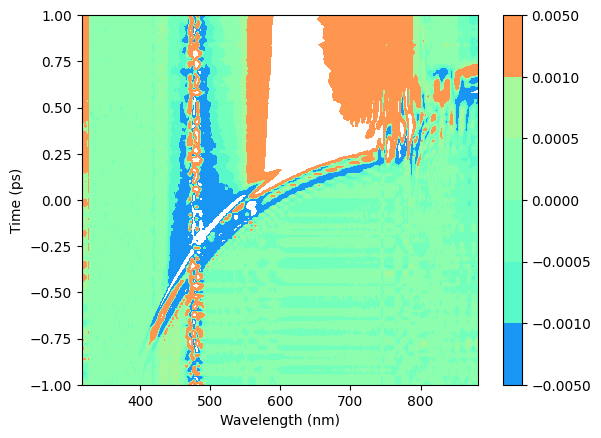

Fitting:   0%|          | 0/1339 [00:00<?, ?it/s]C:\Users\Kent\AppData\Local\Temp\ipykernel_29528\375806657.py:582: RuntimeWarning: overflow encountered in exp
  exp2 = w[4]*np.exp(-(t-w[10])*(k1))*norm.cdf(t-w[10], scale=sigma)
c:\Python311\Lib\site-packages\lmfit\minimizer.py:141: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
C:\Users\Kent\AppData\Local\Temp\ipykernel_29528\375806657.py:583: RuntimeWarning: overflow encountered in exp
  exp3 = w[6]*np.exp(-(t-w[10])*(k2))*norm.cdf(t-w[10], scale=sigma)
Fitting:  21%|██        | 281/1339 [00:07<00:21, 49.96it/s]C:\Users\Kent\AppData\Local\Temp\ipykernel_29528\375806657.py:581: RuntimeWarning: overflow encountered in exp
  exp1 = w[2]*np.exp(-(t-w[10])*(k0))*norm.cdf(t-w[10], scale=sigma)
c:\Python311\Lib\site-packages\lmfit\minimizer.py:141: RuntimeWarning: overflow encountered in multiply
  return (r*r).sum()
Fitting:  22%|██▏       | 301/1339 [00:16<01:03, 16.22it/s]C:\Users\Kent\AppData\Local\Temp\ipykernel_

[316.645574 435.062349 443.52069  451.979031 460.437372 468.895713
 477.354054 485.812395 494.270736 502.729078 511.187419 519.64576
 528.104101 536.562442 545.020783 553.479124 561.937465 570.395806
 578.854147 587.312488 595.770829 604.229171 612.687512 621.145853
 629.604194 638.062535 646.520876 654.979217 663.437558 671.895899
 680.35424  688.812581 697.270922 705.729264 714.187605 722.645946
 731.104287 739.562628 756.47931  773.395992]


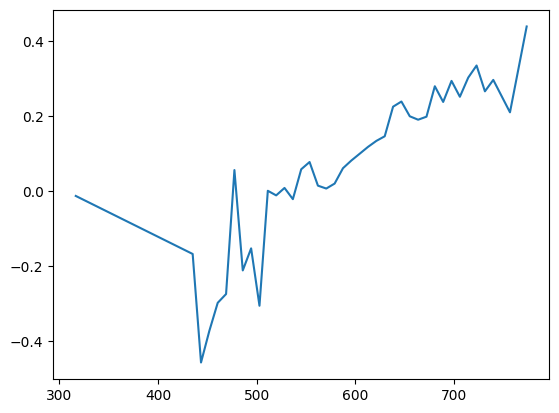

In [7]:
tamatrix = tamatrix_importer('PTCA_NiO_ITO_80nJ_averaged') 
tamatrix.auto_bgcorr(25)
tamatrix.fit_correlation(3)
line = tamatrix.t0_list
print(line[0])
plt.plot(line[0],line[1])



[316.645574 320.874744 325.103915 422.374837 426.604008 430.833178
 435.062349 439.291519 443.52069  447.749861 451.979031 456.208202
 460.437372 464.666543 468.895713 473.124884 477.354054 481.583225
 485.812395 490.041566 494.270736 498.499907 502.729078 506.958248
 511.187419 515.416589 519.64576  523.87493  528.104101 532.333271
 536.562442 540.791612 545.020783 549.249953 553.479124 557.708295
 561.937465 566.166636 570.395806 574.624977 578.854147 583.083318
 587.312488 591.541659 595.770829 600.       604.229171 608.458341
 612.687512 616.916682 621.145853 625.375023 629.604194 633.833364
 638.062535 642.291705 646.520876 650.750047 654.979217 659.208388
 663.437558 667.666729 671.895899 676.12507  680.35424  684.583411
 688.812581 693.041752 697.270922 701.500093 705.729264 709.958434
 714.187605 718.416775 722.645946 726.875116 731.104287 735.333457
 739.562628 743.791798 748.020969 752.250139 756.47931  760.70848
 769.166822 773.395992 777.625163 781.854333 786.083504 794.541

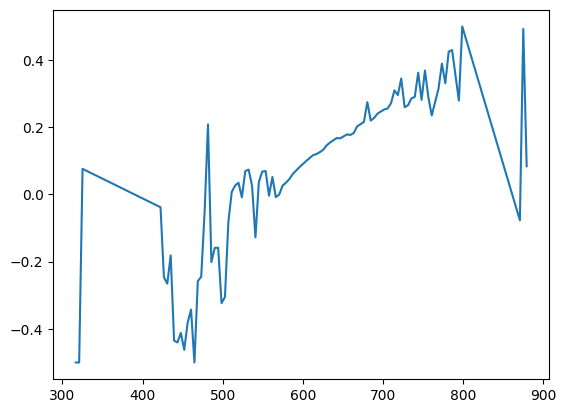

(-0.005, 0.005)

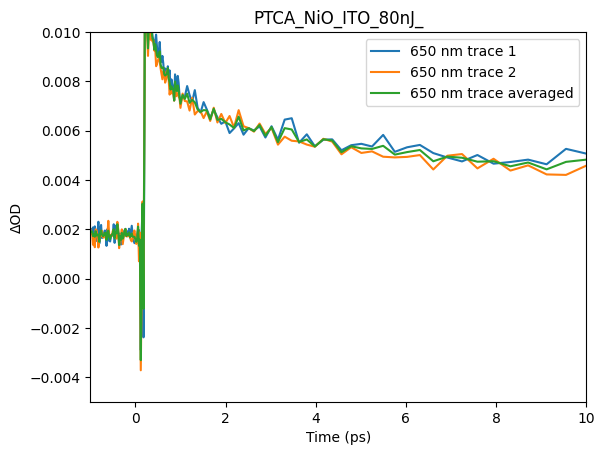

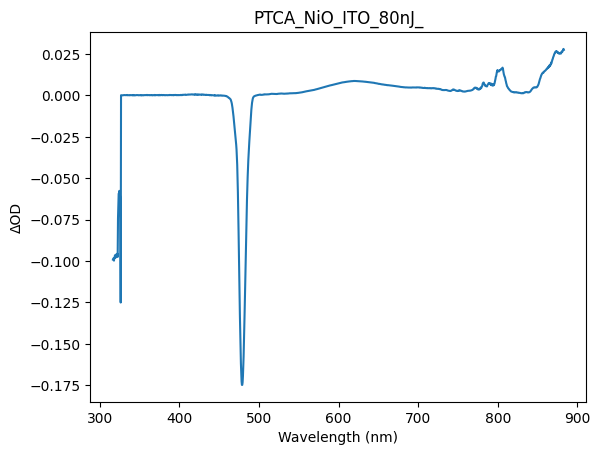

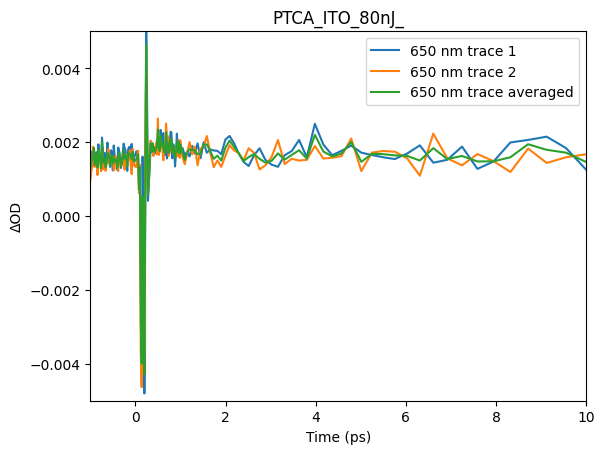

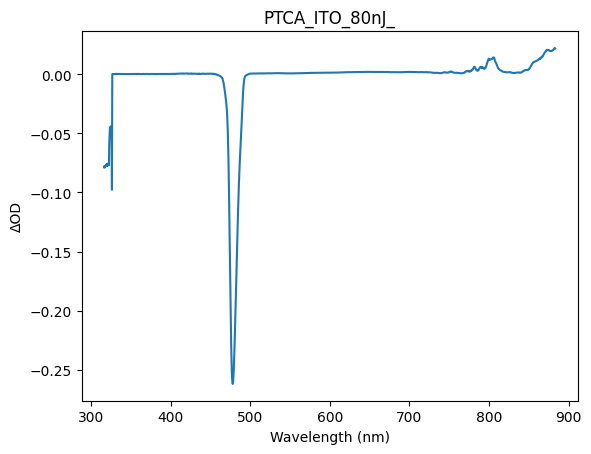

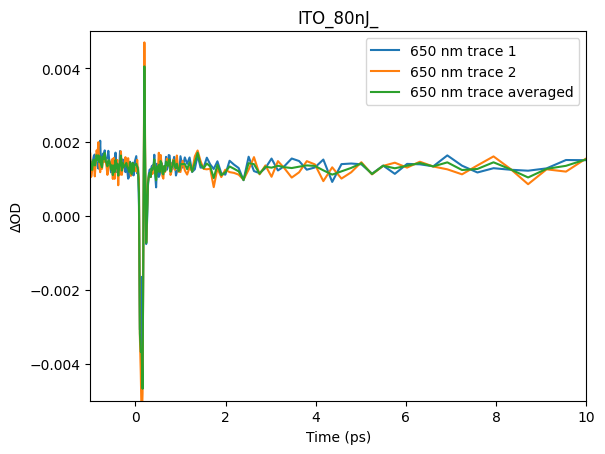

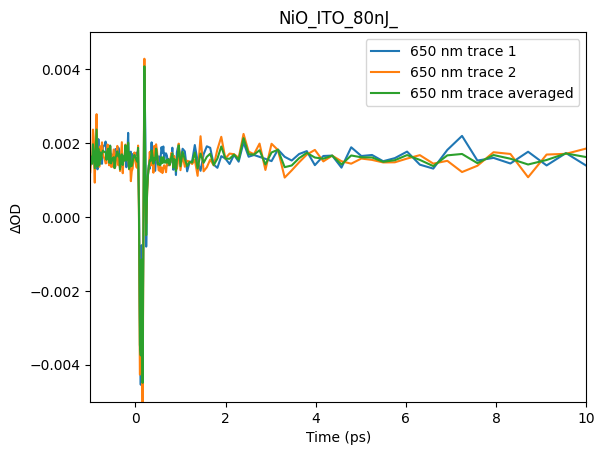

In [142]:
# load data into objects and plot
ptca_nio_ito_80nj = load_spectra('PTCA_NiO_ITO_80nJ_', 2)

ptca_nio_ito_80nj.get_traces(650)  # get traces at 650 nm

ptca_nio_ito_80nj.ax_k.set_xlim(-1, 10)

ptca_nio_ito_80nj.ax_k.set_ylim(-0.005, 0.01)

ptca_nio_ito_80nj.get_1ps()


ptca_ito_80nj = load_spectra('PTCA_ITO_80nJ_', 2)

ptca_ito_80nj.get_traces(650)

ptca_ito_80nj.ax_k.set_xlim(-1, 10)

ptca_ito_80nj.ax_k.set_ylim(-0.005, 0.005)

ptca_ito_80nj.get_1ps()


ito_80nj = load_spectra('ITO_80nJ_', 2)

ito_80nj.get_traces(650)

ito_80nj.ax_k.set_xlim(-1, 10)

ito_80nj.ax_k.set_ylim(-0.005, 0.005)

# ito_80nj.get_1ps()


nio_ito_80nj = load_spectra('NiO_ITO_80nJ_', 2)

nio_ito_80nj.get_traces(650)

nio_ito_80nj.ax_k.set_xlim(-1, 10)

nio_ito_80nj.ax_k.set_ylim(-0.005, 0.005)

# nio_ito_80nj.get_1ps()

In [120]:
def plot_traces(name, trace_num, row_num):
    # Create an empty figure and axis
    fig, ax = plt.subplots()
    # Create x and y data using NumPy
    x = np.loadtxt(name+"_tatime")
    for i in range(trace_num):
        y = np.loadtxt(name+"_row"+str(row_num)+"kinetic_"+str(i+1))
        # Create a plot using Matplotlib
        ax.plot(x, y, label=str(i+1))
    # Add labels and a title to the plot
    plt.xlabel('Time (ps)')
    plt.ylabel('ΔOD')
    plt.title(name)

    # limit to -0.5 to 100 ps
    plt.xlim(-0.5, 100)
    plt.legend()
    # Show the plot
    plt.show()